### Load required libraries

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LeakyReLU, Dropout, Input
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [3]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [7]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [8]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [206]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train, X_train_f = X_train[X_train.Class == 0], X_train[X_train.Class == 1]
X_train, X_train_f = X_train.drop(['Class'], axis=1), X_train_f.drop(['Class'], axis=1)
X_train, X_train_f = X_train.values, X_train_f.values

y_train, y_train_f = np.zeros(X_train.shape[0]), np.ones(X_train.shape[0])

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [218]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

In [222]:
x.size, y.size

(41776, 1492)

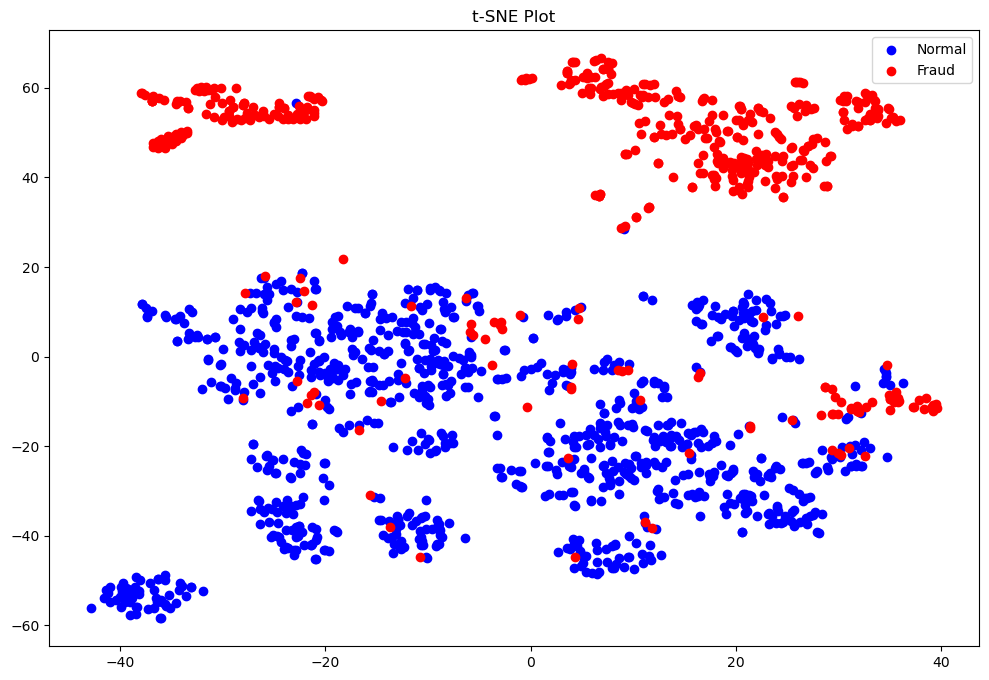

In [18]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

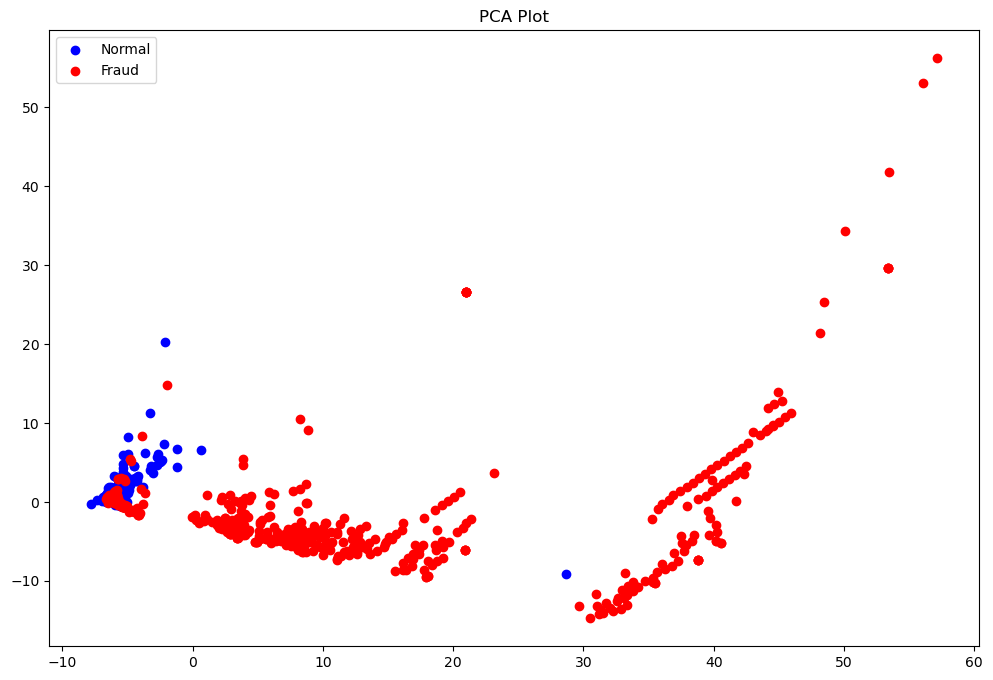

In [21]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [177]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);
scaler.fit_transform(X_train_f);

### Model Construction

In [161]:
def get_generator(latent_dim):
    input_layer = Input(shape=(latent_dim, ))
    generator = Dense(128)(input_layer)
    generator = LeakyReLU(alpha=0.2)(generator)
    
    generator = Dense(256)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    
    generator = Dense(28, activation='tanh')(generator)
    
    generator = Model(inputs= input_layer, outputs=generator)
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    
    generator.summary()
    return generator

In [162]:
def get_discriminator(data_dim):
    input_layer = Input(shape=(data_dim, ))
    discriminator = Dense(256)(input_layer)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    discriminator = Dense(128)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)
    
    discriminator = Dense(1, activation='sigmoid')(discriminator)
    
    discriminator = Model(inputs= input_layer, outputs=discriminator)
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    discriminator.summary()
    return discriminator

In [163]:
def get_GAN(discriminator, latent_dim, generator):
    
    discriminator.trainable = False
    
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer='adam')
    
    gan.summary()
    return gan

In [164]:
BATCH_SIZE = 32
EPOCHS= 100
NOISE_DIM = 32
RANDOM_DIM = 32
DATA_DIM = X_train.shape[1]

### Training

In [211]:
def train(x_train, y_train, x_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE, random_dim = RANDOM_DIM):

    G = get_generator(RANDOM_DIM)
    D = get_discriminator(DATA_DIM)
    gan = get_GAN(D, RANDOM_DIM, G)
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    history = []

    for epoch in range(epochs):
        print('Epoch %d' % epoch)
            
        # Train discriminator
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        legit_data = x_train[idx]  # Real data
            
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_data = G.predict(noise) # Fake data

        D.trainable = True
        d_loss_real = D.train_on_batch(legit_data, valid)
        d_loss_fake = D.train_on_batch(gen_data, fake)
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
            
            
        # Train generator 
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        D.trainable = False
        g_loss = gan.train_on_batch(noise, valid)
        
        history.append({"D":d_loss[0],"G":g_loss})

            
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
    
    return history

In [212]:
normal_history = train(X_train, y_train, X_test, y_test)

Model: "model_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_164 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_331 (Dense)           (None, 128)               4224      
                                                                 
 leaky_re_lu_220 (LeakyReLU  (None, 128)               0         
 )                                                               
                                                                 
 dense_332 (Dense)           (None, 256)               33024     
                                                                 
 leaky_re_lu_221 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 dense_333 (Dense)           (None, 28)                71

1/1 [==============================] - 0s 28ms/step
40 [D loss: 0.359083, acc.: 85.94%] [G loss: 1.881003]
Epoch 41
1/1 [==============================] - 0s 30ms/step
41 [D loss: 0.586722, acc.: 82.81%] [G loss: 1.971628]
Epoch 42
1/1 [==============================] - 0s 22ms/step
42 [D loss: 0.511089, acc.: 85.94%] [G loss: 2.148322]
Epoch 43
1/1 [==============================] - 0s 34ms/step
43 [D loss: 0.409816, acc.: 84.38%] [G loss: 2.276291]
Epoch 44
1/1 [==============================] - 0s 47ms/step
44 [D loss: 0.187823, acc.: 93.75%] [G loss: 2.620760]
Epoch 45
1/1 [==============================] - 0s 53ms/step
45 [D loss: 0.250205, acc.: 93.75%] [G loss: 3.028393]
Epoch 46
1/1 [==============================] - 0s 43ms/step
46 [D loss: 0.332581, acc.: 89.06%] [G loss: 3.417447]
Epoch 47
1/1 [==============================] - 0s 32ms/step
47 [D loss: 0.310693, acc.: 90.62%] [G loss: 3.699149]
Epoch 48
1/1 [==============================] - 0s 30ms/step
48 [D loss: 0.186877

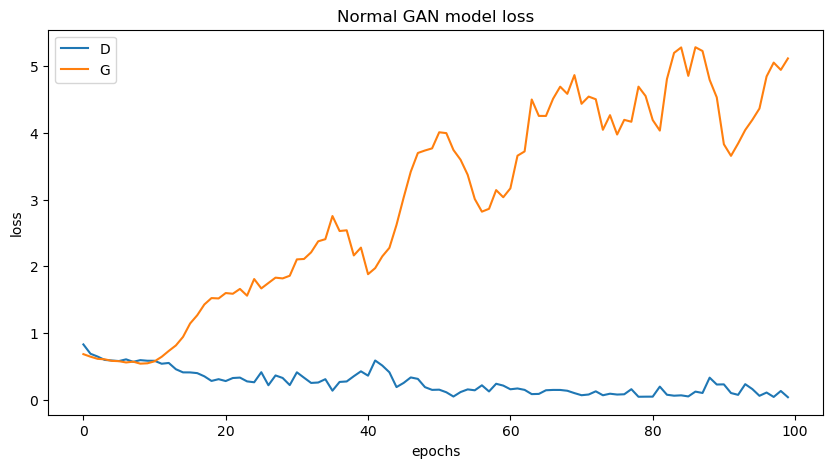

In [213]:
hist = pd.DataFrame(normal_history)
plt.figure(figsize=(10,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.title('Normal GAN model loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [214]:
gen_data = G.predict(tf.random.normal([1000, NOISE_DIM]))
gen_data.shape

32/32 [==============================] - 0s 3ms/step


(1000, 28)

In [215]:
gen_data

array([[-1.54918119e-01,  1.12273112e-01, -2.41915041e-04, ...,
         7.23338053e-02, -2.37683594e-01,  1.30247593e-01],
       [ 2.95901924e-01,  2.16204345e-01, -3.49072255e-02, ...,
        -8.73758420e-02, -4.74969715e-01,  1.30681217e-01],
       [ 1.06343724e-01,  2.30669584e-02,  8.60316902e-02, ...,
        -2.36846164e-01, -4.47848201e-01,  2.57070158e-02],
       ...,
       [ 1.22624308e-01,  4.66820329e-01,  1.62481546e-01, ...,
        -2.05962613e-01, -5.03973424e-01,  4.02369767e-01],
       [-1.87933758e-01,  5.34726977e-01, -5.27039289e-01, ...,
        -4.18528169e-02, -4.35726970e-01,  4.60486710e-01],
       [-9.56525505e-02,  8.27949762e-01, -2.32439622e-01, ...,
        -3.91490072e-01, -7.06961274e-01,  3.80766056e-02]], dtype=float32)

In [216]:
fraud_history = train(X_train_f, y_train_f, X_test, y_test,100,16)

Model: "model_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_167 (InputLayer)      [(None, 32)]              0         
                                                                 
 dense_337 (Dense)           (None, 128)               4224      
                                                                 
 leaky_re_lu_224 (LeakyReLU  (None, 128)               0         
 )                                                               
                                                                 
 dense_338 (Dense)           (None, 256)               33024     
                                                                 
 leaky_re_lu_225 (LeakyReLU  (None, 256)               0         
 )                                                               
                                                                 
 dense_339 (Dense)           (None, 28)                71

1/1 [==============================] - 0s 37ms/step
40 [D loss: 0.199032, acc.: 96.88%] [G loss: 1.860890]
Epoch 41
1/1 [==============================] - 0s 40ms/step
41 [D loss: 0.157248, acc.: 96.88%] [G loss: 1.822027]
Epoch 42
1/1 [==============================] - 0s 36ms/step
42 [D loss: 0.229130, acc.: 90.62%] [G loss: 1.911625]
Epoch 43
1/1 [==============================] - 0s 32ms/step
43 [D loss: 0.189384, acc.: 96.88%] [G loss: 1.830610]
Epoch 44
1/1 [==============================] - 0s 26ms/step
44 [D loss: 0.158968, acc.: 100.00%] [G loss: 1.694153]
Epoch 45
1/1 [==============================] - 0s 31ms/step
45 [D loss: 0.130351, acc.: 100.00%] [G loss: 1.758617]
Epoch 46
1/1 [==============================] - 0s 30ms/step
46 [D loss: 0.135858, acc.: 100.00%] [G loss: 1.759469]
Epoch 47
1/1 [==============================] - 0s 34ms/step
47 [D loss: 0.226770, acc.: 96.88%] [G loss: 1.683565]
Epoch 48
1/1 [==============================] - 0s 33ms/step
48 [D loss: 0.132

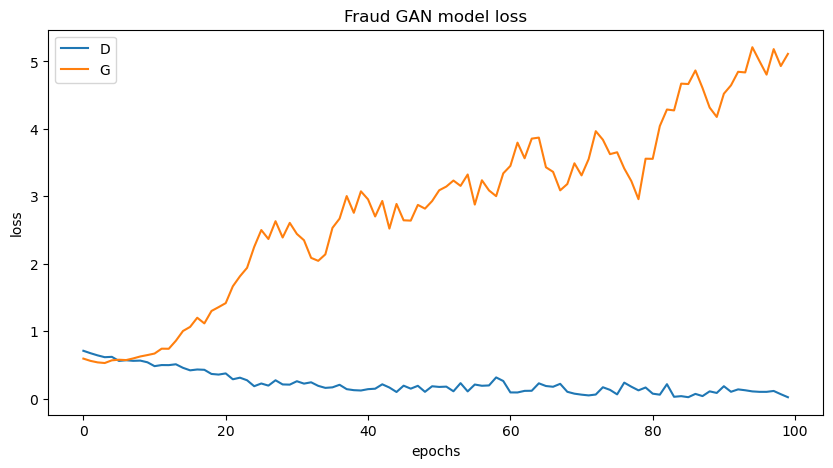

In [217]:
hist = pd.DataFrame(history)
plt.figure(figsize=(10,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.title('Fraud GAN model loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [223]:
gen_data_f = G.predict(tf.random.normal([1492, NOISE_DIM]))
gen_data_f.shape

47/47 [==============================] - 0s 2ms/step


(1492, 28)

In [224]:
gen_data_f

array([[-0.32773864,  0.2329278 , -0.5837538 , ..., -0.5037452 ,
        -0.7440927 ,  0.4591462 ],
       [ 0.0595196 ,  0.097516  , -0.4674987 , ...,  0.45117834,
        -0.23071334,  0.47241125],
       [ 0.03238838,  0.08158837,  0.1336742 , ..., -0.445985  ,
        -0.56671786,  0.02290572],
       ...,
       [-0.42430273, -0.18685801, -0.075007  , ..., -0.123624  ,
        -0.48937565,  0.33400643],
       [ 0.00998166,  0.40623152, -0.10502952, ...,  0.15259272,
        -0.30591556, -0.08726363],
       [-0.03682112, -0.05568194, -0.49499395, ..., -0.02292069,
        -0.5264329 ,  0.14093944]], dtype=float32)

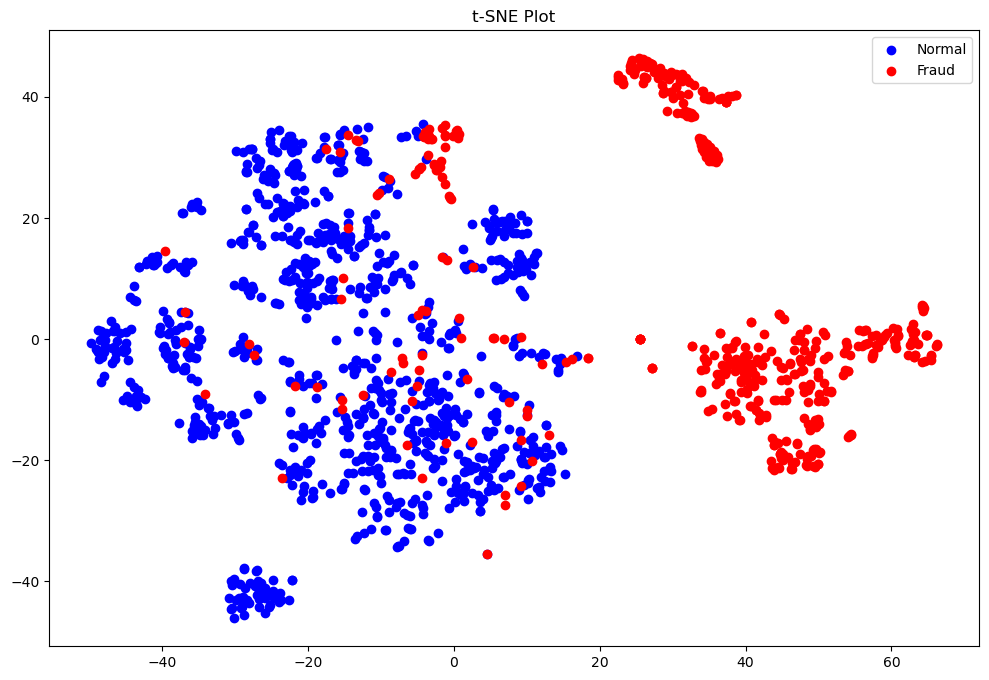

In [226]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

In [227]:
x3 = gen_data
x4 = gen_data_f

genClass3 = np.full((x3.shape[0], 1), 2)
genClass4 = np.full((x4.shape[0], 1), 3)

x3 = np.hstack((x3, genClass3))
x4 = np.hstack((x4, genClass4))

x3 = pd.DataFrame(x3)
x4 = pd.DataFrame(x4)

x3.columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
              'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
              'V21','V22','V23','V24','V25','V26','V27','V28','Class']

x4.columns = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
              'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
              'V21','V22','V23','V24','V25','V26','V27','V28','Class']


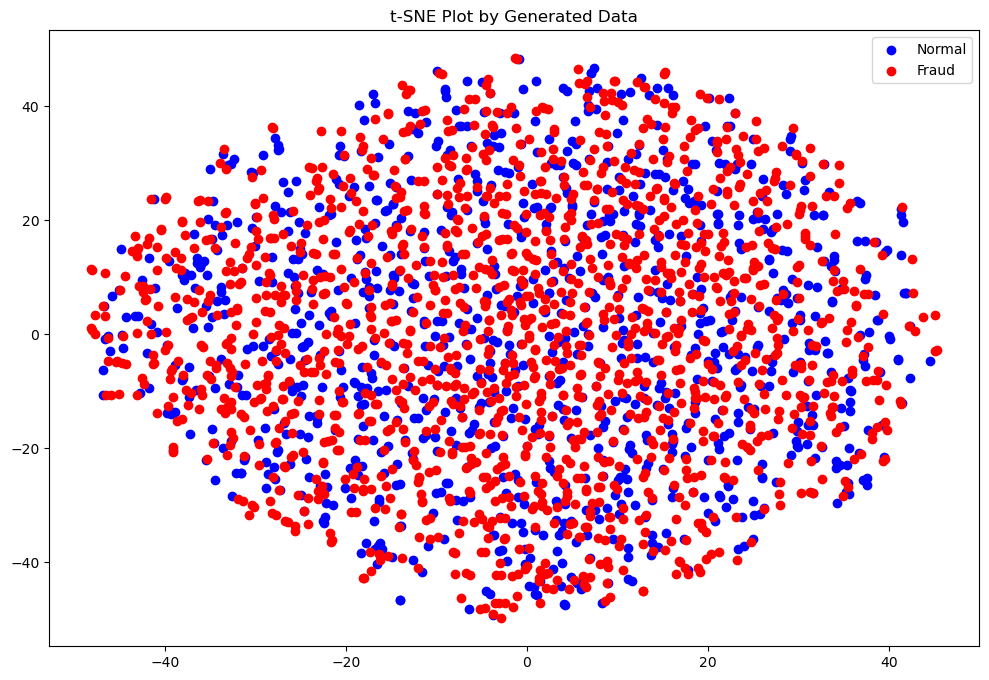

In [229]:
dfd = x3.append(x4).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==2), 0], y=xtsne[np.where(y==2), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==3), 0], y=xtsne[np.where(y==3), 1], color="red", label='Fraud')
plt.title('t-SNE Plot by Generated Data')
plt.legend()
plt.show()